# Experiment: California Housing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from sklearn.datasets import fetch_california_housing  

housing = fetch_california_housing() 
x = housing.data
y = housing.target.reshape(-1,1)
x=preprocessing.StandardScaler().fit(x).transform(x) #normalize
x=pd.DataFrame(x)
y=pd.DataFrame(y)
data=pd.concat([y,x],axis=1)
train,test=train_test_split(data,test_size=0.3, random_state=1)

train_y = train.iloc[:,0]
train_x = train.iloc[:,1:]
test_y = test.iloc[:,0]
test_x = test.iloc[:,1:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x

,0,1,2,3,4,5,6,7
0,-0.503149,-1.083767,-0.462001,0.018689,1.535208,-0.036385,-0.689106,0.648722
1,-0.364659,0.982143,-0.418034,-0.088311,0.205330,0.054431,-0.857653,0.653714
2,-0.715648,1.617807,-0.219152,-0.279204,-0.119633,-0.035265,0.523497,-0.089991
3,-0.700173,-1.083767,0.410511,0.687172,1.008909,-0.065649,-0.735924,1.502236
4,0.333002,-1.719432,-0.055459,0.009491,0.276858,-0.050146,0.762273,-1.128183
...,...,...,...,...,...,...,...,...
14443,-1.099272,-0.924851,-0.555332,-0.020087,-0.305957,-0.057375,-0.876380,0.843383
14444,2.468780,1.061601,0.549474,-0.179651,-0.593833,-0.016802,-0.567377,-0.030095
14445,-1.441260,1.061601,-0.217538,-0.189596,-0.574406,-0.040979,-0.796789,0.653714
14446,-0.651904,-1.481058,-0.176785,-0.305747,-0.090492,-0.028604,-0.890426,1.202758


In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [183]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>50 and float(test_loss)>max(dnn_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 4.962285041809082
            Test  set - loss: 3.096064805984497
            
epoch 10
            Train set - loss: 0.5311615467071533
            Test  set - loss: 0.5458918809890747
            
epoch 20
            Train set - loss: 0.5907847881317139
            Test  set - loss: 0.522179901599884
            
epoch 30
            Train set - loss: 0.93902987241745
            Test  set - loss: 0.4989260733127594
            
epoch 40
            Train set - loss: 0.3674393892288208
            Test  set - loss: 0.47624966502189636
            
epoch 50
            Train set - loss: 0.4997473955154419
            Test  set - loss: 0.4570975601673126
            
epoch 60
            Train set - loss: 0.29355189204216003
            Test  set - loss: 0.44354176521

In [184]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.6120067  0.79238224 2.4416616  ... 1.6179008  1.4398905  2.0246122 ]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_testloss=[]
    t0=time.time()
    for epoch in range(500): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>50 and float(test_loss)>max(dnn_testloss[-50:-1]):
            break
        dnn_testloss.append(float(test_loss))
    
    x0=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(len(test_y)):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/len(test_y)
print("95 coverage",dnn_coverage)

## 2. Resnet

In [164]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(8,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-5,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(500):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>50 and float(test_loss)>max(res_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=8, out_features=32, bias=True)
    (fc2): Linear(in_features=8, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 4.7699503898620605
            Test  set - loss: 4.383410453796387
            
epoch 10
            Train set - loss: 1.519543170928955
            Test  set - loss: 1.8586506843566895
            
epoch 20
            Train set - loss: 0.6003670692443848
            Test  set - loss: 0.8379544019699097
            
epoch 30
            Train set - loss: 1.5545803308486938
            Test  set - loss: 0.6370044350624084
            
epoch 40
            Train set - loss: 0.9199407696723938
            Test  set - loss: 0.6014798879623413
            
epoch 50
            Train 

In [165]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.1444266 1.0015223 2.6912699 ... 1.8199186 1.4129188 1.591355 ]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [ ]:
#bootstrap  
boottime=40
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    t0=time.time()
    for epoch in range(1000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,38]-bootbase)
upper=bootbase-(sorted_bootlist[:,1]-bootbase)
print("confidence interval length",sorted_bootlist[:,38]-sorted_bootlist[:,1])
resnet_length=(sorted_bootlist[:,38]-sorted_bootlist[:,1]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

## Random Feature

definition of random feature

In [68]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

## 3. multilayer learning

In [179]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(8,32,kernel='C',gamma=0.05)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.5)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=3e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>50 and float(test_loss)>max(kernelnn_testloss[-50:-1]):
        break
    
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.5856660604476929
            Test  set - loss: 1.1556642055511475
            
epoch 10
            Train set - loss: 0.7577387690544128
            Test  set - loss: 1.041704535484314
            
epoch 20
            Train set - loss: 0.9951913952827454
            Test  set - loss: 0.7474534511566162
            
epoch 30
            Train set - loss: 0.734358549118042
            Test  set - loss: 0.4937024712562561
            
epoch 40
            Train set - loss: 0.9077057838439941
            Test  set - loss: 0.43317580223083496
            
epoch 50
            Train set - loss: 0.5989112257957458
            Test  set - loss: 0.4131951630115509
            
epoch 60
            Train set - loss: 0.6998719573020935
            Test  set - loss: 0.39679041504859924
            
epoch 70
            Train set 

In [180]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.6622286 1.065842  2.6223087 ... 1.7846265 1.3863032 1.4049994]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [ ]:
#bootstrap  
boottime=40
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9) #optim.Adam(...)

    t0 = time.time()
    for epoch in range(1000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,38]-bootbase)
upper=bootbase-(sorted_bootlist[:,1]-bootbase)
print("confidence interval length",sorted_bootlist[:,38]-sorted_bootlist[:,1])
kernelnet_length=(sorted_bootlist[:,38]-sorted_bootlist[:,1]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/300
print("95 coverage",kernelnet_coverage)

## 4. Residual multilayer learning

In [170]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(8,32,kernel='C',gamma=0.05)
rff1=RandomFourierFeature(32,8,kernel='G',gamma=0.5)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=5)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        y = rff.transform(x)
        x = self.fc1(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.rblock2 = ResidualBlock(8,8,rff2)
        self.fc3 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-5,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>50 and float(test_loss)>max(reskernel_testloss[-50:-1]):
        break
    
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 4.880493640899658
            Test  set - loss: 4.624267101287842
            
epoch 10
            Train set - loss: 0.9627683758735657
            Test  set - loss: 1.1202067136764526
            
epoch 20
            Train set - loss: 1.022413969039917
            Test  set - loss: 0.873497486114502
            
epoch 30
            Train set - loss: 0.9179925322532654
            Test  set - loss: 0.7247681617736816
            
epoch 40
            Train set - loss: 0.9603262543678284
            Test  set - loss: 0.6208391785621643
            
epoch 50
            Train

In [171]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.6803591 0.837787  2.605927  ... 1.4488628 1.2534035 1.6414096]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [ ]:
#bootstrap  
boottime=40
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9) #optim.Adam(...)

    t0 = time.time()
    for epoch in range(1000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,38]-bootbase)
upper=bootbase-(sorted_bootlist[:,1]-bootbase)
print("confidence interval length",sorted_bootlist[:,38]-sorted_bootlist[:,1])
reskernelnet_length=(sorted_bootlist[:,38]-sorted_bootlist[:,1]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

In [ ]:
length=[dnn_length,resnet_length,kernelnet_length,reskernelnet_length]
coverage=[10*dnn_coverage,10*resnet_coverage,10*kernelnet_coverage,10*reskernelnet_coverage]
name=['dnn','resnet','mulyi-kernel','res-kernel']
print(length,coverage)
plt.bar(name,length)
plt.bar(name,coverage)
plt.legend(['length','coverage(10%)'])
plt.title("95% confidence interval")
plt.show()

comparison

In [132]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

DNN vs multilayer kernel

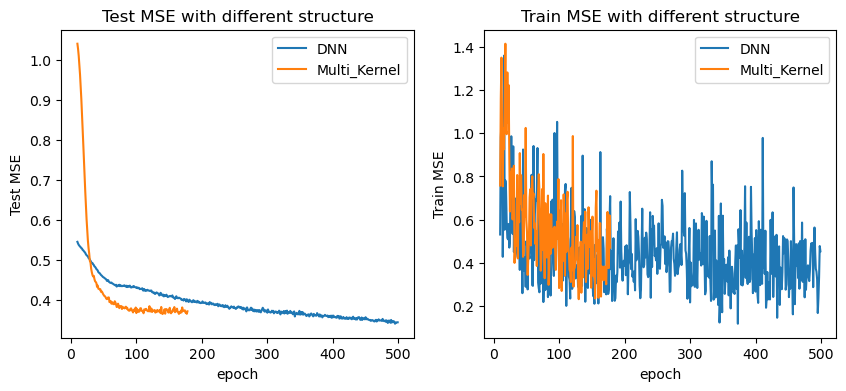

In [181]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],10,dnn_testloss)
plot_choose(ax[0],10,kernelnn_testloss)
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],10,dnn_trainloss)
plot_choose(ax[1],10,kernelnn_trainloss)
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

Resnet vs multilayer residual kernel

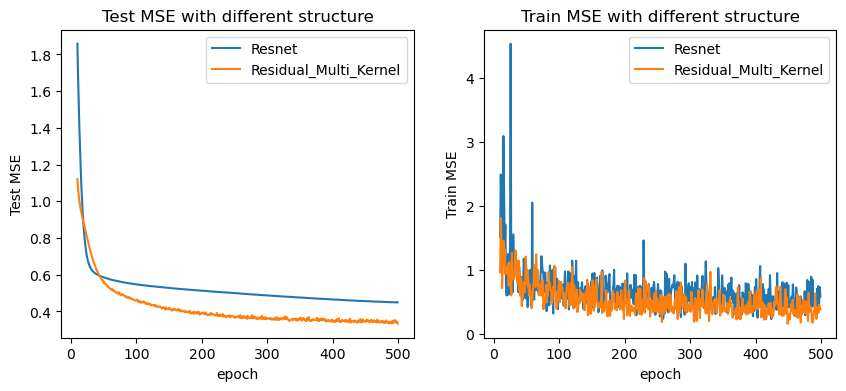

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],10,res_testloss)
plot_choose(ax[0],10,reskernel_testloss)
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],10,res_trainloss)
plot_choose(ax[1],10,reskernel_trainloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()